# Beta

- The beta of a stock is defined as the slope in:
`stock_returns - rf = a + b * (market_returns - rf) + error`
- with market_returns = S&P 500
- with rf = risk-free rate
- if beta is 1, it means the stock moves identical to the market
- a lower beta means the stock is less volatile than the market

In [1]:
import pandas_datareader.data as reader
import datetime as dt
import matplotlib.pyplot as plt

In [2]:
end = dt.datetime.now()
start = dt.date(end.year - 5, end.month, end.day)
stocks = ["MSFT", "^GSPC"]

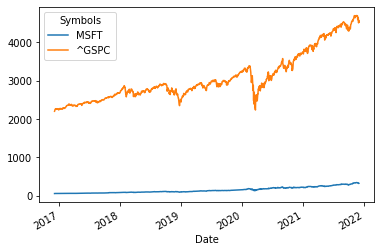

In [3]:
df = reader.get_data_yahoo(stocks, start, end)["Adj Close"]
df.plot()
plt.show()

In [4]:
monthly_returns = df.resample("M").ffill().pct_change()
monthly_returns = monthly_returns.dropna(axis=0)
monthly_returns.head()

Symbols,MSFT,^GSPC
Date,,
2017-01-31,0.040393,0.017884
2017-02-28,-0.004364,0.037198
2017-03-31,0.029384,-0.000389
2017-04-30,0.039478,0.009091
2017-05-31,0.026005,0.011576


## Using sklearn LinearRegression

In [5]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
X = monthly_returns.assign(bias=1)[["^GSPC", "bias"]].values.reshape(monthly_returns.shape[0], 2)
y = monthly_returns["MSFT"].values.reshape(monthly_returns.shape[0], 1)
print(X[:5])
model.fit(X, y)
model.score(X, y)

[[ 1.78843582e-02  1.00000000e+00]
 [ 3.71981601e-02  1.00000000e+00]
 [-3.89197135e-04  1.00000000e+00]
 [ 9.09120875e-03  1.00000000e+00]
 [ 1.15762512e-02  1.00000000e+00]]


0.5445367835908328

In [6]:
model.coef_

array([[0.87935227, 0.        ]])

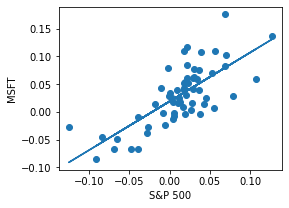

In [7]:
plt.figure(figsize=(4, 3))
ax = plt.axes()
ax.scatter(X[:, 0], y)
ax.plot(X[:, 0], model.predict(X))

ax.set_xlabel('S&P 500')
ax.set_ylabel('MSFT')

ax.axis('tight')

plt.show()

## Using statsmodels Ordinary Least Squares

In [8]:
import statsmodels.api as sm

X = monthly_returns["^GSPC"]
y = monthly_returns["MSFT"]

X_sm = sm.add_constant(X)
model = sm.OLS(y, X_sm)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   MSFT   R-squared:                       0.545
Model:                            OLS   Adj. R-squared:                  0.537
Method:                 Least Squares   F-statistic:                     69.34
Date:                Sun, 05 Dec 2021   Prob (F-statistic):           1.74e-11
Time:                        17:36:18   Log-Likelihood:                 115.42
No. Observations:                  60   AIC:                            -226.8
Df Residuals:                      58   BIC:                            -222.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0192      0.005      3.962      0.000       0.009       0.029
^GSPC          0.8794      0.106      8.327      0.000       0.668       1.091
==============================================================================
Omnibus:                        2.755   Durbin-Watson:                   2.495
Prob(Omnibus):                  0.252   Jarque-Bera (JB):                2.350
Skew:                           0.485   Prob(JB):                        0.309
Kurtosis:                       2.980   Cond. No.                         22.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [9]:
rf = reader.DataReader("F-F_Research_Data_Factors", "famafrench", start, end)[0].RF
rf = rf[1:]
print(rf.shape)
rf.tail()

(58,)


Date
2021-06    0.0
2021-07    0.0
2021-08    0.0
2021-09    0.0
2021-10    0.0
Freq: M, Name: RF, dtype: float64

In [10]:
monthly_returns = monthly_returns.iloc[:-2]

print(monthly_returns.shape)
monthly_returns.tail()

(58, 2)


Symbols,MSFT,^GSPC
Date,,
2021-06-30,0.084989,0.022214
2021-07-31,0.051717,0.022748
2021-08-31,0.061591,0.028990
2021-09-30,-0.066119,-0.047569
2021-10-31,0.176291,0.069144


In [11]:
monthly_returns["MSFT-rf"], monthly_returns["^GSPC-rf"] = monthly_returns["MSFT"] - rf.values, monthly_returns["^GSPC"] - rf.values
monthly_returns.head()

Symbols,MSFT,^GSPC,MSFT-rf,^GSPC-rf
Date,,,,
2017-01-31,0.040393,0.017884,0.000393,-0.022116
2017-02-28,-0.004364,0.037198,-0.044364,-0.002802
2017-03-31,0.029384,-0.000389,-0.000616,-0.030389
2017-04-30,0.039478,0.009091,-0.010522,-0.040909
2017-05-31,0.026005,0.011576,-0.033995,-0.048424


In [12]:
model_rf = LinearRegression()
X = monthly_returns.assign(bias=1)[["^GSPC-rf", "bias"]].values.reshape(monthly_returns.shape[0], 2)
y = monthly_returns["MSFT-rf"].values.reshape(monthly_returns.shape[0], 1)
model_rf.fit(X, y)
model_rf.score(X, y)

0.8608127016664759

In [13]:
model_rf.coef_

array([[0.93590981, 0.        ]])

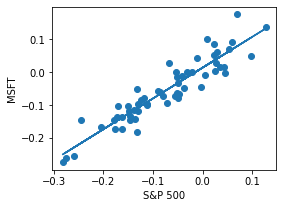

In [14]:
plt.figure(figsize=(4, 3))
ax = plt.axes()
ax.scatter(X[:, 0], y)
ax.plot(X[:, 0], model_rf.predict(X))

ax.set_xlabel('S&P 500')
ax.set_ylabel('MSFT')

ax.axis('tight')

plt.show()